# Denoising 1d signal

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(42)

In [2]:
from tramp.models import DAGModel
from tramp.base import SISOVariable, SIMOVariable, MILeafVariable
from tramp.likelihoods import GaussianLikelihood
from tramp.channels import DFTChannel, Blur1DChannel, GradientChannel
from tramp.priors import GaussBernouilliPrior, GaussianPrior
from tramp.algos import ExpectationPropagation, StateEvolution, TrackEvolution, EarlyStopping, JoinCallback

In [3]:
plt.rc("text", usetex=True)
logger.setLevel(logging.INFO)

In [4]:
def plot_data():
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False, sharex=True)
    axs[0].plot(t, x, label=r"$x(t)$")
    axs[0].plot(t, y, ".", label=r"$y(t)$")
    axs[0].legend()
    axs[0].set(xlabel=r"$t$")
    axs[1].plot(t, x_prime, label=r"$x'(t)$")
    axs[1].legend()
    axs[1].set(xlabel=r"$t$")
    fig.tight_layout()
    
def plot_prediction(r_pred):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False, sharex=True)
    axs[0].plot(t, r_pred["x"], label="pred")
    axs[0].plot(t, x, label="true")
    axs[0].legend()
    axs[0].set(xlabel=r"$t$", ylabel=r"$x(t)$")
    x_grad_pred = r_pred["x'"].ravel()
    x_prime_pred = x_grad_pred/dt
    axs[1].plot(t, x_prime_pred, label="pred")
    axs[1].plot(t, x_prime, label="true")
    axs[1].legend()
    axs[1].set(xlabel=r"$t$", ylabel=r"$x'(t)$")
    fig.tight_layout()
    
def run_model(model):
    callback = EarlyStopping(tol=1e-6, min_variance=1e-15)
    ep = ExpectationPropagation(model)
    ep.iterate(max_iter=30, callback=callback)
    r_pred = {x_id: data["r"] for x_id, data in ep.get_variables_data().items()}
    v_pred = {x_id: data["v"] for x_id, data in ep.get_variables_data().items()}
    x_mse = mean_squared_error(x, r_pred["x"])  
    print(f"n_iter={ep.n_iter}")
    print(f"v_pred={v_pred}")
    print(f"x_mse={x_mse}")
    plot_prediction(r_pred)

## L2 gradient denoising

We use as prior information:

- mean and var of $x$
- var of $\nabla x$

var_prior = 0.500 var_grad = 7.89e-03 var_noise=0.010


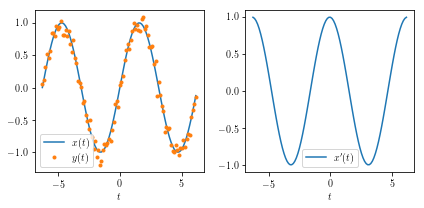

In [5]:
# signal
N = 100
grad = GradientChannel(shape=(N,))
var_noise = 0.01
t = np.linspace(-2*np.pi,2*np.pi,100, endpoint=False)
dt = t[1] - t[0]
x = np.sin(t)
x_shape = np.shape(x)
x_grad = grad.convolve(x).ravel()
x_prime = x_grad/ dt
y = x + np.sqrt(var_noise)*np.random.randn(N)
var_prior = x.var()
var_grad = x_grad.var()
print(f"var_prior = {var_prior:.3f} var_grad = {var_grad:.2e} var_noise={var_noise:.3f}")
plot_data()

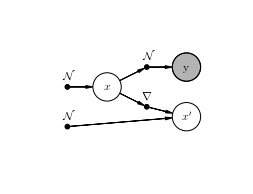

In [6]:
# smooth derivative model
grad_shape = (1,) + x_shape
smooth_grad = (
    GaussianPrior(size=N, var=var_prior) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            GaussianPrior(size=grad_shape, var=var_grad)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
smooth_grad = DAGModel(smooth_grad)
smooth_grad.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: all tolerances are below tol=1.00e-06
INFO:root:terminated after n_iter=3 iterations


n_iter=3
v_pred={'x': 0.0040113809524454005, "x'": 0.0046589431164746394}
x_mse=0.0023527003803405317


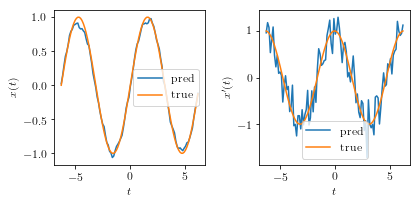

In [7]:
run_model(smooth_grad)

## Sparse gradient denoising

We use as prior information:

- mean and var of $x$
- sparsity of $\nabla x$

In [8]:
def between(x, xmin, xmax):
    return (xmin < x) &  (x<xmax)

mean_prior=0.510 var_prior=0.510 rho_grad=0.040 var_grad=2.50 var_noise=0.010


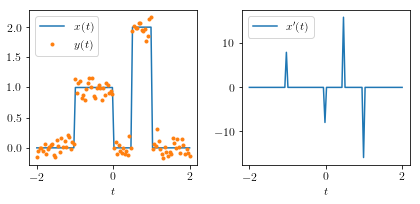

In [9]:
# signal
N = 100
grad = GradientChannel(shape=(N,))
var_noise = 0.01
t = np.linspace(-2,2,100)
x = 1*between(t, -1, 0) + 2*between(t, 0.5, 1)
x_shape = np.shape(x)
x_grad = grad.convolve(x).ravel()
x_prime = x_grad / dt
y = x + np.sqrt(var_noise)*np.random.randn(N)
mean_prior = x.mean()
var_prior = x.var()
nonzero = np.abs(x_grad)>1e-6
rho_grad = nonzero.mean()
var_grad = x_grad[nonzero].var()
print(
    f"mean_prior={mean_prior:.3f} var_prior={var_prior:.3f}"
    f" rho_grad={rho_grad:.3f} var_grad={var_grad:.2f} var_noise={var_noise:.3f}"
)
plot_data()

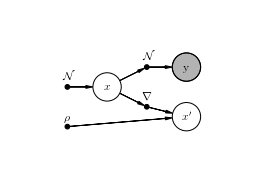

In [10]:
# sparse derivative model
grad_shape = (1,) + x_shape
sparse_grad = (
    GaussianPrior(size=N, mean=mean_prior, var=var_prior) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            GaussBernouilliPrior(size=grad_shape, var=var_grad, rho=rho_grad)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
sparse_grad = DAGModel(sparse_grad)
sparse_grad.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:new_v=0.002419598454344114>old_v=0.0016291653840983622 for SIMOVariable(n_prev=1,n_next=2,id=x)
INFO:root:new_v=0.001747444276175862>old_v=0.0010298595151862753 for MILeafVariable(n_prev=2,n_next=0,id=x')
INFO:root:terminated after n_iter=3 iterations


n_iter=3
v_pred={'x': 0.0016291653840983622, "x'": 0.0010298595151862753}
x_mse=0.001502610536816734


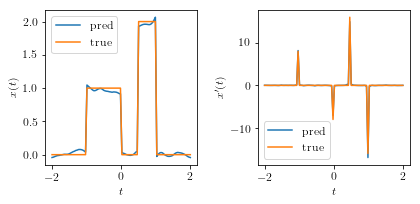

In [11]:
run_model(sparse_grad)